In [76]:
#fix weird branch stuff
#download libraries
%pip install Pillow
%pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import tensorflow as tf
import os

In [78]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [79]:
print(tf.config.list_physical_devices('GPU'))

[]


In [80]:
#1: Get training data

#import images
from PIL import Image
from pathlib import Path

#count files in a folder
def count_files_in_folder(folder_path):
    folder = Path(folder_path)
    return sum(1 for item in folder.iterdir() if item.is_file())

#set folder path to l_training data
folder_path = 'data'
num_files = count_files_in_folder(folder_path)

imagelib = []

#store all files into library to use for data training
for i in range(num_files):
    imagelib.append("data/league_of_legends/img" + str(i + 1) +".png")

#verify correct number of files
print(len(imagelib))

#open image with line below
#image = Image.open(filename)

0


In [81]:
#2 Load Data

import numpy as np
from matplotlib import pyplot as plt

In [82]:
#build data pipeline
data = tf.keras.utils.image_dataset_from_directory(folder_path)

Found 27 files belonging to 2 classes.


In [83]:
#access generator from data pipeline
#data_iterator = data.as_numpy_iterator()

In [84]:
#resizes image to fit the batch, 
#batch = data_iterator.next()

In [85]:
#show array of league of legends, vs destiny (we can tell by the sample of images that league is 1 and destiny is 0)
#class 1 = league
#class 0 = destiny
#batch[0] is all the images
#batch[1] are labels
#batch[1]

In [86]:
#3 preprocess data
#applies the scaling while the data is being loaded
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [87]:
batch[0].max()

1.0

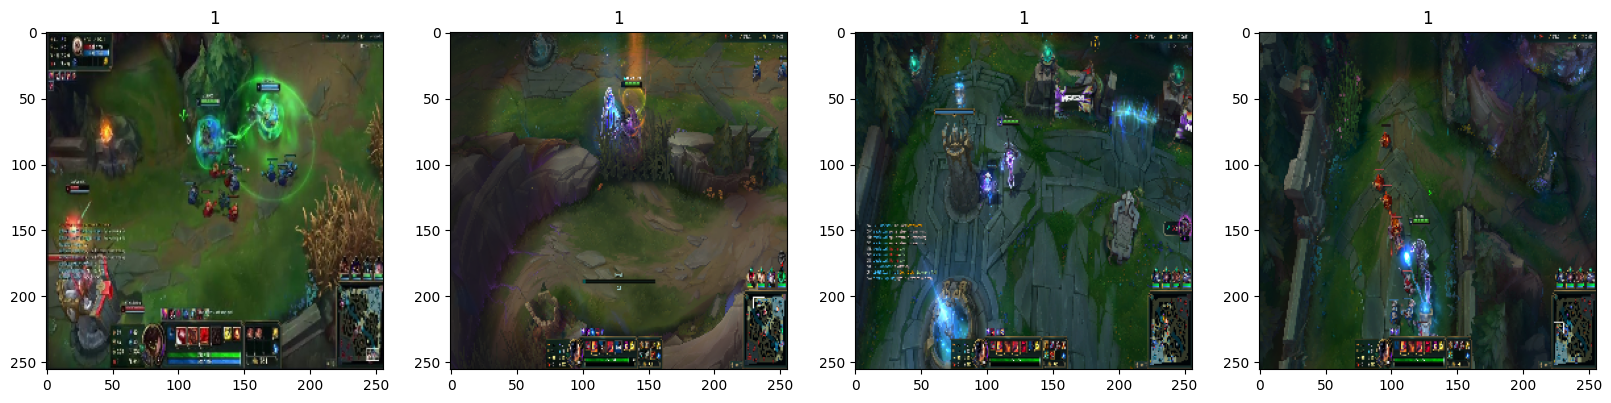

In [88]:
#visualize data with matplotlib
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [89]:
len(data)

1

In [90]:
#Split data into training, validation and testing
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1

In [91]:
#ensure that values add up into the length of the batches
train_size+val_size+test_size

2

In [92]:
#make sure data is shuffled before, in this case we already have shuffled the data with initial batch
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [93]:
#Sequential models great if you have one data input and one data output
#functional api is better if you have multiple inputs and multiple outputs
from tensorflow.keras.models import Sequential

#Conv2d is a 2d convolution layer (spatial convolution over images)
#maxpooling2d condenses all the values in a region and returns max
#Flatten turns convolution into a format that dense can understand
#dropout for regularization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [94]:
#Establish model
model = Sequential()

In [95]:
#add neural network layers
#scans layers to detect data, 16 filters, 3 by 3 filter, move by 1 pixel each time
#pass all data into relu function to modify the output data
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#return maximum value from the relu activation over a set region, reduce image data by half
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#condense rows and width, numbers of filters will form channel value but we don't want channel value so flatten removes that
#condenses into a single dimension (rows * width * filters)
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\ds\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [96]:
#adam is a optimizer
#binary crossentropy losses are incorrect predictions? since we are determining numbers 0 and 1 from our final neural network layer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [97]:
#shows application of every layer and the 
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
#Train data

logdir ='logs'

In [99]:
#save the model at a certain state
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
#plot out data
#train : training data
#epochs : how long we train for, 1 epoch is 1 run through data
#validation_data : run evaluation on validation data
#ideally we want to see loss go down and accuracy go up
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
#plot performance

#plot loss metrics
fig = plt.figure()

#training loss is teal
plt.plot(hist.history['loss'], color='teal', label='loss')

#validation loss has orange color
#if val loss going up and loss going down it means model is overfitting, so apply regularization or change data
#if loss isn't decreasing at all, make a larger/sophisticated neural network or look again at training data
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
#visualize accuracy

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
#evaluate metrics
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
#run through each batch in testing data
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


In [ ]:
#print result
#higher values ensure that model works better
print(f'Precision:{pre.result().numpy()}, Recall:{ re.result().numpy()}, Accuracy{acc.result().numpy()}')

In [ ]:
#test on new data
#uncomment lines below to test data
#img = cv2.imread('154006829.jpg')
#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.show()

In [ ]:
#resize image to throw into neural network
#resize = tf.image.resize(img, (256,256))
#plt.show()

In [ ]:
#throw into model
#put into list because model is taking batches and not taking singular lists
#yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
#if yhat > 0.5: 
   # print(f'Predicted class is Sad')
#else:
   # print(f'Predicted class is Happy')

In [ ]:
#Save the model
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','gameidentifiermodel.h5'))

In [ ]:
#load the model
#new_model = load_model(os.path.join('models','gameidentifiermodel.h5'))